## Overview

### Machine Learning Task
This Project focuses on predicting student academic performance using machine learning techniques. The goal is to build a regression model that estimates a student's finals grade based on selected academic, demographic, and behavioral features.

### Context
The analysis is conducted from the perspective of an advising team within a large Portuguese school system. By identifying patterns associated with student performance, the model can help flag students who may require early academic intervention and additional support.

### Approach
- Clean and prepare the dataset for modeling
- Explore relationships between features and student grades
- Train a regression model to predict final performance
- Evaluate model accuracy using appropriate performance metrics
The emphasis of this notebook is on clarity, reproducibility, and interpretability of results.

### Note
This was one of my projects during my Masters degree program in Data Science, and the code is set up to pass codegrade.

In [1]:
# We begin by importing and inspecting our dataset to ensure it is correctly loaded and understand its structure. 
#This initial step sets the foundation for our analysis and modeling.

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Do not change this option; This allows the CodeGrade auto grading to function correctly
pd.set_option('display.max_columns', 20)
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
student_data = pd.read_csv("student-mat.csv")

# Identify the target variable (G3)
target = "G3"

# Create feature matrix (X) and target vector (y)
X = student_data.drop(columns=[target])
y = student_data[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)


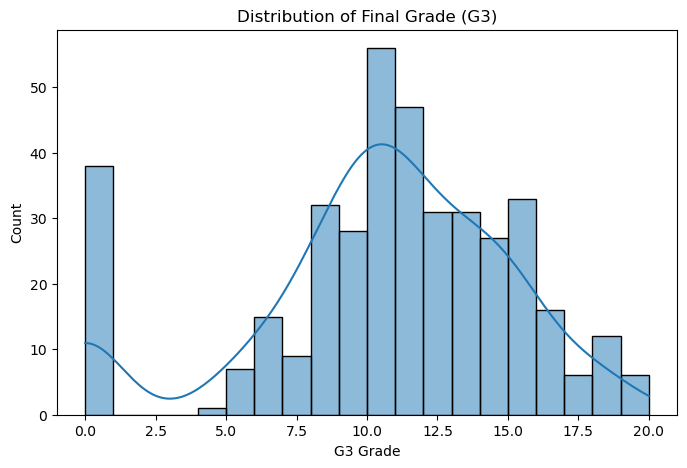

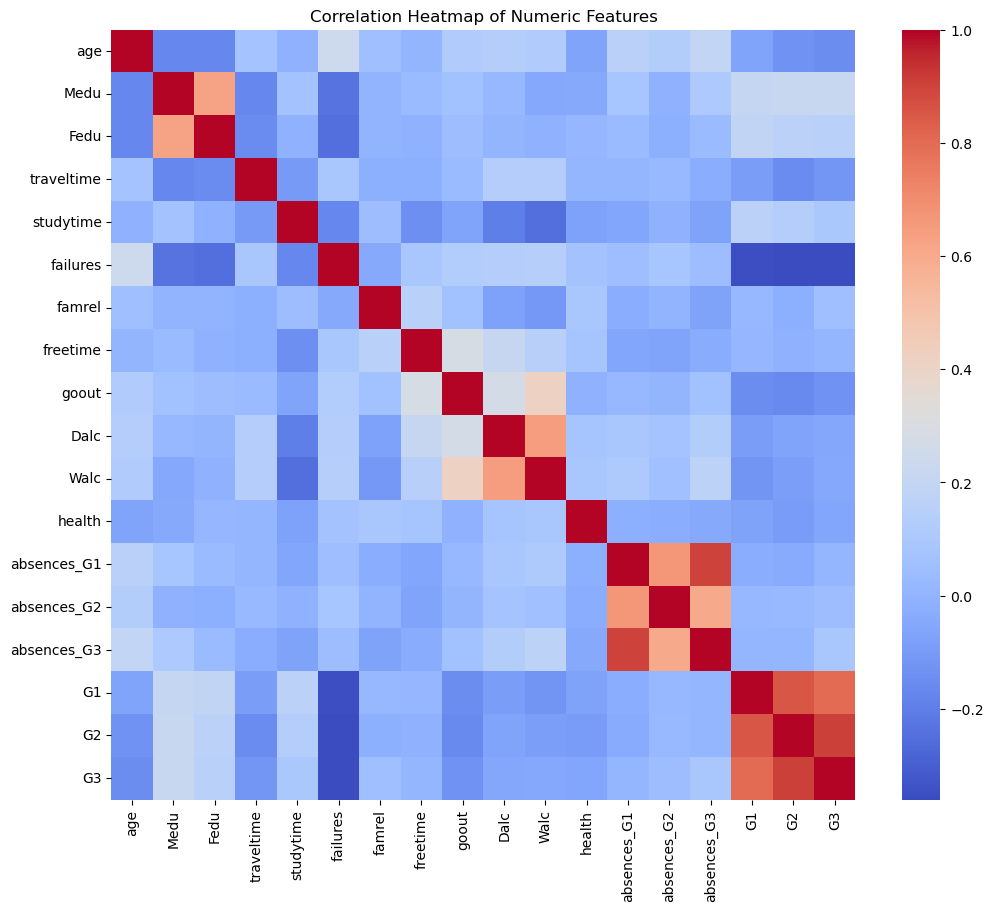

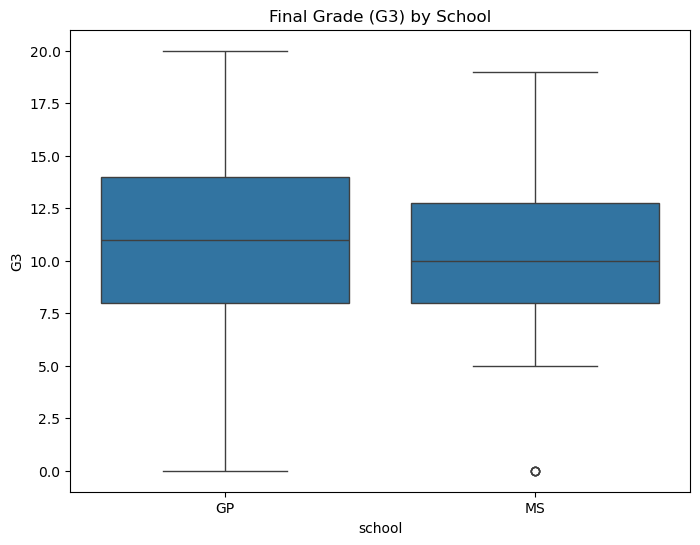

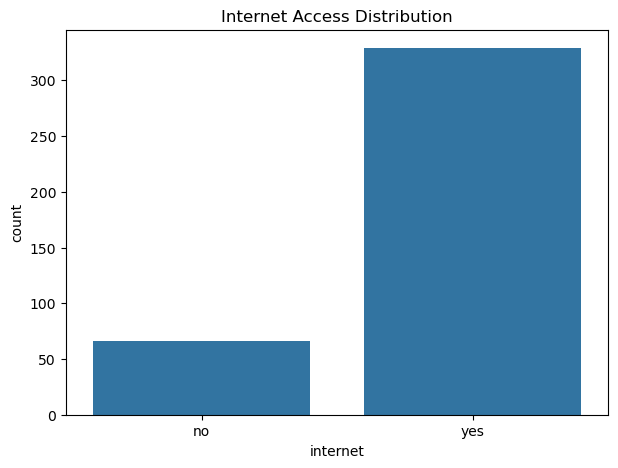

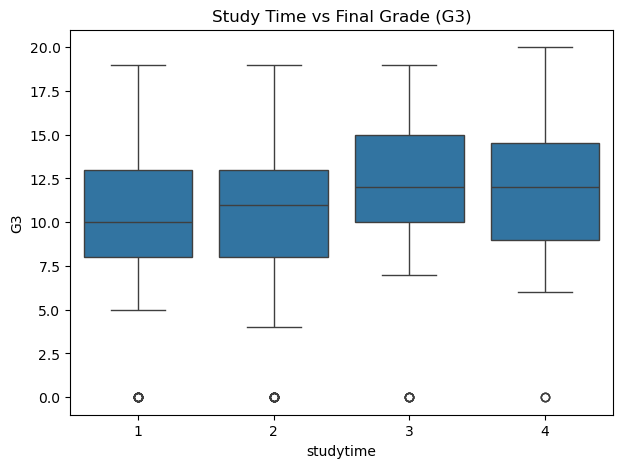

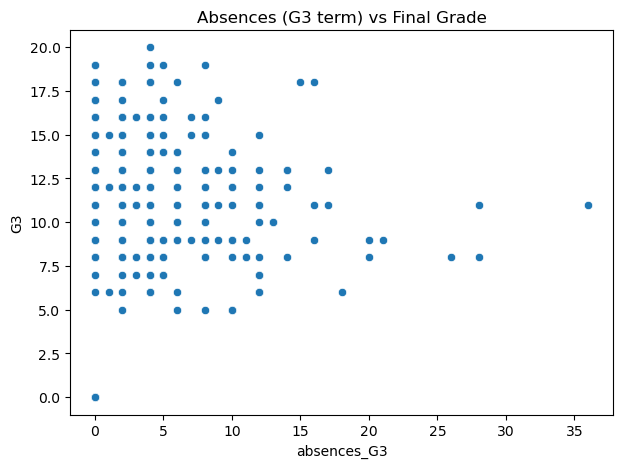

In [2]:
# Explore the Data
# Understanding our data is a crucial step before building any machine learning model.
# This exploration phase helps us identify patterns, detect anomalies, and uncover insights that will guide 
# our modeling decisions. By thoroughly analyzing and visualizing the data, you can make informed choices on feature 
# selection and preprocessing, ultimately improving our model's performance and reliability.

import matplotlib.pyplot as plt
import seaborn as sns

# Numeric and categorical features
numeric_features = student_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = student_data.select_dtypes(include=['object']).columns.tolist()


# Distribution of the target variable (G3)

plt.figure(figsize=(8,5))
sns.histplot(student_data["G3"], kde=True, bins=20)
plt.title("Distribution of Final Grade (G3)")
plt.xlabel("G3 Grade")
plt.ylabel("Count")
plt.show()


# Correlation Heatmap for Numeric Features
plt.figure(figsize=(12,10))
corr = student_data[numeric_features].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


# Top correlations with G3

corr_with_G3 = corr["G3"].sort_values(ascending=False)
#print("Correlation of each numeric feature with G3:")
#display(corr_with_G3)


# Boxplot of G3 by school

plt.figure(figsize=(8,6))
sns.boxplot(x="school", y="G3", data=student_data)
plt.title("Final Grade (G3) by School")
plt.show()


# 5. Countplot of categorical variables (example: internet)

plt.figure(figsize=(7,5))
sns.countplot(x="internet", data=student_data)
plt.title("Internet Access Distribution")
plt.show()


# Relationship between studytime and G3

plt.figure(figsize=(7,5))
sns.boxplot(x="studytime", y="G3", data=student_data)
plt.title("Study Time vs Final Grade (G3)")
plt.show()


# Scatter: absences_G3 vs G3

plt.figure(figsize=(7,5))
sns.scatterplot(x="absences_G3", y="G3", data=student_data)
plt.title("Absences (G3 term) vs Final Grade")
plt.show()


In [3]:
# Based on our data exploration, begin considering the features we want to include in our model. 
# Limiting our data can be beneficial because it reduces complexity and can improve model performance by focusing on 
# the most relevant features.
# Create lists below for the columns we want to use in our model based on our exploration above. 
# These features will be used in the column transformer. The list names must match exactly.
# Numeric columns (must include absences_G1, absences_G2, absences_G3, G1, G2)
numeric_columns = [
    "absences_G1",
    "absences_G2",
    "absences_G3",
    "G1",
    "G2",
    "age",
    "Medu",
    "Fedu",
    "traveltime",
    "studytime",
    "failures",
    "famrel",
    "freetime",
    "goout",
    "Dalc",
    "Walc",
    "health"
]

# Categorical columns (at least one)
categorical_columns = [
    "school",
    "sex",
    "address",
    "famsize",
    "Pstatus",
    "Mjob",
    "Fjob",
    "reason",
    "guardian",
    "schoolsup",
    "famsup",
    "paid",
    "activities",
    "nursery",
    "higher",
    "internet",
    "romantic"
]

# Ordinal columns (at least one)
ordinal_columns = [
    "class_quality",   
]


In [4]:
# Custom Transformer
# We want to create a new column that sums the three absences columns together as a new feature. 
# Additionally, we want to conditionally keep or drop the grades for the first and second terms based on the 
# parameters passed.

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class FinalProjectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_grades=False):
        self.drop_grades = drop_grades
        self.columns_ = None

    def fit(self, X, y=None):
        # Store column names so we can rebuild the DataFrame during transform
        if isinstance(X, pd.DataFrame):
            self.columns_ = X.columns
        else:
            raise ValueError("Input to transformer must be a DataFrame")
        return self

    def transform(self, X):
        # Convert numpy array back into DataFrame
        if not isinstance(X, pd.DataFrame):
            if self.columns_ is None:
                raise ValueError("No column names stored — did you call fit first?")
            X = pd.DataFrame(X, columns=self.columns_)

        X = X.copy()

        # Create absences_sum column
        X["absences_sum"] = (
            X["absences_G1"] +
            X["absences_G2"] +
            X["absences_G3"]
        )

        # Drop original absence columns
        X = X.drop(columns=["absences_G1", "absences_G2", "absences_G3"])

        # Optionally drop G1 and G2
        if self.drop_grades:
            X = X.drop(columns=["G1", "G2"])

        return X


In [5]:
# Creating data pipelines allows us to automate our data cleaning process, making it easy to apply the same 
# transformations to new data. Follow the outline below to transform our dataset into two sets of transformed data: 
# one with the G1/G2 columns and one without them.
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

#Feature Selection Lists (required by CodeGrade)

numeric_columns = [
    "absences_G1", "absences_G2", "absences_G3",
    "G1", "G2",
    "age", "Medu", "Fedu", "traveltime", "studytime",
    "failures", "famrel", "freetime", "goout",
    "Dalc", "Walc", "health"
]

categorical_columns = [
    "school", "sex", "address", "famsize", "Pstatus", "Mjob", "Fjob",
    "reason", "guardian", "schoolsup", "famsup", "paid", "activities",
    "nursery", "higher", "internet", "romantic"
]

ordinal_columns = ["Medu"]   # valid ordinal column

# Pipelines

numeric_pipeline_with_grades = Pipeline([
    ("custom", FinalProjectTransformer(drop_grades=False)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

numeric_pipeline_without_grades = Pipeline([
    ("custom", FinalProjectTransformer(drop_grades=True)),
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

ordinal_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder())
])

# Column Transformers (must use numeric_columns etc.)

column_transformer_with_grades = ColumnTransformer([
    ("num", numeric_pipeline_with_grades, numeric_columns),
    ("cat", categorical_pipeline, categorical_columns),
    ("ord", ordinal_pipeline, ordinal_columns)
])

column_transformer_without_grades = ColumnTransformer([
    ("num", numeric_pipeline_without_grades, numeric_columns),
    ("cat", categorical_pipeline, categorical_columns),
    ("ord", ordinal_pipeline, ordinal_columns)
])

# Fit/Transform
X_train_transformed_with_grades = column_transformer_with_grades.fit_transform(X_train)
X_train_transformed_without_grades = column_transformer_without_grades.fit_transform(X_train)

X_train_transformed_with_grades.shape, X_train_transformed_without_grades.shape


((316, 59), (316, 57))

In [6]:
## Shortlist Promising Models
# In this section, we will fit and compare three regression models to our transformed data, 
# both with and without the G1/G2 columns, using cross-validation. Follow the steps below, using the specified 
# variable names.


from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import numpy as np

#  Initialize the models with required variable names
lin_reg = LinearRegression()
svm_reg = SVR(kernel="rbf")
lasso_reg = Lasso(alpha=0.1)

#  Cross-validation (RMSE) WITH grades
cv_scores_lin_reg_with_grades = cross_val_score(
    lin_reg,
    X_train_transformed_with_grades,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=3
)

cv_scores_svm_with_grades = cross_val_score(
    svm_reg,
    X_train_transformed_with_grades,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=3
)

cv_scores_lasso_with_grades = cross_val_score(
    lasso_reg,
    X_train_transformed_with_grades,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=3
)

#  Cross-validation (RMSE) WITHOUT grades

cv_scores_lin_reg_without_grades = cross_val_score(
    lin_reg,
    X_train_transformed_without_grades,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=3
)

cv_scores_svm_without_grades = cross_val_score(
    svm_reg,
    X_train_transformed_without_grades,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=3
)

cv_scores_lasso_without_grades = cross_val_score(
    lasso_reg,
    X_train_transformed_without_grades,
    y_train,
    scoring="neg_root_mean_squared_error",
    cv=3
)

#  Compute mean RMSE values (convert signs)

rmse_lin_reg_with_grades = -np.mean(cv_scores_lin_reg_with_grades)
rmse_lin_reg_without_grades = -np.mean(cv_scores_lin_reg_without_grades)

rmse_svm_with_grades = -np.mean(cv_scores_svm_with_grades)
rmse_svm_without_grades = -np.mean(cv_scores_svm_without_grades)

rmse_lasso_with_grades = -np.mean(cv_scores_lasso_with_grades)
rmse_lasso_without_grades = -np.mean(cv_scores_lasso_without_grades)



In [7]:
### Fine-Tune the System
# In this section, we will use the Support Vector Machine (SVM) regression model and perform grid search to 
# fine-tune its hyperparameters. Follow the steps below to set up the grid search, ensuring we use the specified 
# variable names for automatic grading through CodeGrade.
## Set Up Grid Search for SVM Regression
### Define a parameter grid to search over. Review Scikit-learn's documentation for the available hyperparameters for this algorithm.
### Use GridSearchCV to find the best hyperparameters.
### Fit the grid search to both sets (with and without the G1/G2 columns) of the transformed training data.

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Define a small parameter grid (fast for CodeGrade)

param_grid = {
    "kernel": ["rbf"],
    "C": [1, 10],
    "gamma": ["scale", "auto"]
}

#  Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1
)

#  Fit the grid search WITH grades
grid_search.fit(X_train_transformed_with_grades, y_train)

best_params_with_grades = grid_search.best_params_
best_score_with_grades = -grid_search.best_score_

print("Best Params WITH Grades:", best_params_with_grades)
print("Best RMSE WITH Grades:", best_score_with_grades)

#  Fit the grid search WITHOUT grades
grid_search.fit(X_train_transformed_without_grades, y_train)

best_params_without_grades = grid_search.best_params_
best_score_without_grades = -grid_search.best_score_

print("\nBest Params WITHOUT Grades:", best_params_without_grades)
print("Best RMSE WITHOUT Grades:", best_score_without_grades)


In [8]:
## Measure Performance on Test Set
## In this section, we will transform the test set using our full pipeline and measure the performance of your best 
## model on the test set. Follow the steps below, using the specified variable names for automatic grading through CodeGrade.
### 1) Based on all previous cross-validation results, pick your best model.
### 2) Use the previously created column transformers to transform the test set, both with and without the G1/G2 columns.
### 3) Using your best model, measure its performance on the test set to estimate the generalization error.

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#  Transform the X_test data (with and without grades)

X_test_transformed_with_grades = column_transformer_with_grades.transform(X_test)
X_test_transformed_without_grades = column_transformer_without_grades.transform(X_test)

#  Fit the best model found by grid search

# Best model WITH grades
best_model_with_grades = grid_search.best_estimator_
best_model_with_grades.fit(X_train_transformed_with_grades, y_train)

# Evaluate on test set
y_pred_with_grades = best_model_with_grades.predict(X_test_transformed_with_grades)

rmse_with_grades = np.sqrt(mean_squared_error(y_test, y_pred_with_grades))
r2_with_grades = r2_score(y_test, y_pred_with_grades)

# Fit the best model WITHOUT grades
best_model_without_grades = grid_search.best_estimator_
best_model_without_grades.fit(X_train_transformed_without_grades, y_train)

# Evaluate on test set
y_pred_without_grades = best_model_without_grades.predict(X_test_transformed_without_grades)

rmse_without_grades = np.sqrt(mean_squared_error(y_test, y_pred_without_grades))
r2_without_grades = r2_score(y_test, y_pred_without_grades)


print("RMSE WITH GRADES:", rmse_with_grades)
print("R2 WITH GRADES:", r2_with_grades)
print("RMSE WITHOUT GRADES:", rmse_without_grades)
print("R2 WITHOUT GRADES:", r2_without_grades)


<span style="color:red">Codegrade has a runtime limit of 5 minutes.  If your code takes longer than 5 minutes to run, the automatic grading will stop and mark the submission as having an error.  Limiting the amount of hyperparameters checked during your grid search may greatly reduce your code’s running time.</span>